# Solve a RBC model

Last update: Oct 27nd, 2020

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Parameterization
alpha = 1.0 / 3
beta = 0.99
gamma = 1.0
delta = 0.025

# A very simple z process
n_z = 2
z_grid = np.array([-0.01, 0.01])
P = np.array([[0.8, 0.2], [0.2, 0.8]])

In [4]:
# Utility function
def u(c, gamma):
    if (c < 0):
        return -1e10
    elif (gamma == 1.0):
        return np.log(c)
    else:
        return (c ** (1 - gamma)) / (1 - gamma)

In [5]:
# Production function
def f(z, k, alpha):
    return np.exp(z) * (k ** alpha)

Up to now are some parameterizations and function definitions.

In [6]:
# Make a grid
n_k = 100
k_grid = np.linspace(1.0, 40, n_k)

In [19]:
%%time

T = 100
V = np.zeros((T, n_z, n_k))

# Loops are slow.
for i in range(T - 1):
    for j in range(n_z):
        for k in range(n_k):
            V[i + 1, j, k] = -1e10
            for kp in range(n_k):
                c = f(z_grid[j], k_grid[k], alpha) - (k_grid[kp] - (1 - delta) * k_grid[k])
                tmp = u(c, gamma) + beta * np.dot(P[j, :], V[i, :, kp])
                if (tmp > V[i + 1, j, k]):
                    V[i + 1, j, k] = tmp
                    

Wall time: 11.4 s


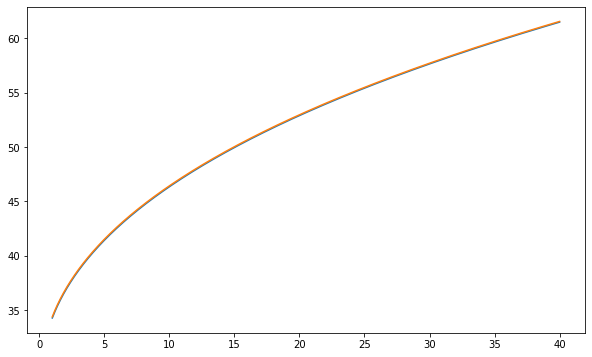

In [25]:
plt.figure(figsize = (10, 6))
plt.plot(k_grid, V[T - 1, :, :].T)
plt.show()

In [10]:
def u_vec(c, gamma):
    if (gamma == 1.0):
        res = np.log(c)
    else:
        res = (c ** (1 - gamma)) / (1 - gamma)
    
    res[np.isnan(res)] = -1e10
    
    return res

In [18]:
%%time

# Vectorize some operations
T = 100
V = np.zeros((T, n_z, n_k))

for i in range(T - 1):
    for j in range(n_z):
        for k in range(n_k):
            V[i + 1, j, k] = -1e10
            c_grid = f(z_grid[j], k_grid[k], alpha) + (1 - delta) * k_grid[k] - k_grid
            tmp = u_vec(c_grid, gamma) + beta * np.dot(P[j, :], V[i, :, :])
            V[i + 1, j, k] = np.max(tmp)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Wall time: 418 ms


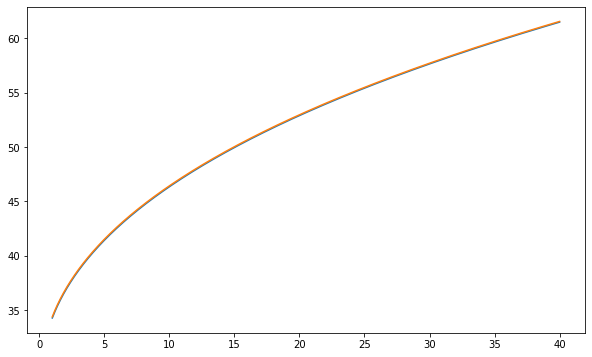

In [26]:
plt.figure(figsize = (10, 6))
plt.plot(k_grid, V[T - 1, :, :].T)
plt.show()

In [39]:
# Scale up a bit?
n_k = 1000
k_grid = np.linspace(1.0, 40, n_k)

In [45]:
%%time

# Vectorize some operations
T = 100
V = np.zeros((T, n_z, n_k))
policy = np.zeros((n_z, n_k))

for i in range(T - 1):
    for j in range(n_z):
        for k in range(n_k):
            V[i + 1, j, k] = -1e10
            c_grid = f(z_grid[j], k_grid[k], alpha) + (1 - delta) * k_grid[k] - k_grid
            tmp = u_vec(c_grid, gamma) + beta * np.dot(P[j, :], V[i, :, :])
            V[i + 1, j, k] = np.max(tmp)
            policy[j, k] = k_grid[np.argmax(tmp)]

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Wall time: 11 s


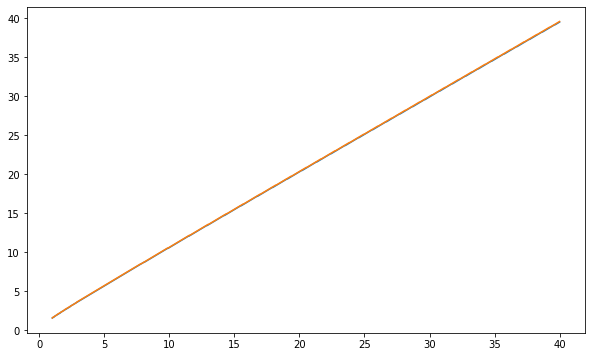

In [48]:
plt.figure(figsize = (10, 6))
plt.plot(k_grid, policy.T)
plt.show()